### Load KITTI Dataset in Python

In [4]:
import pykitti

# Correct base directory (should point to "dataset/")
basedir = "/home/deepak-bhagat/Downloads/data_odometry_velodyne/dataset/"

# Only specify sequence number
sequence = "00"  # Test sequence 00

# Load KITTI odometry dataset
dataset = pykitti.odometry(basedir, sequence)

# Check the number of frames
print(f"Loaded {len(dataset.timestamps)} frames from sequence {sequence}")


Loaded 4541 frames from sequence 00


### Visualize LiDAR Data

In [16]:
import open3d as o3d
import numpy as np

# Load the first LiDAR frame (frame 0)
scan = dataset.get_velo(0)

# Convert to Open3D point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(scan[:, :3])  # Use x, y, z coordinates

# Visualize the LiDAR point cloud
o3d.visualization.draw_geometries([pcd])


### Implement Basic ICP SLAM

In [17]:
def icp_slam(source, target):
    """Applies Iterative Closest Point (ICP) for SLAM"""
    icp = o3d.pipelines.registration.registration_icp(
        source, target, 0.2, np.eye(4),
        o3d.pipelines.registration.TransformationEstimationPointToPoint())
    return icp.transformation

# Load two consecutive LiDAR frames
pcd1 = o3d.geometry.PointCloud()
pcd1.points = o3d.utility.Vector3dVector(dataset.get_velo(0)[:, :3])

pcd2 = o3d.geometry.PointCloud()
pcd2.points = o3d.utility.Vector3dVector(dataset.get_velo(1)[:, :3])

# Compute transformation using ICP
transformation = icp_slam(pcd1, pcd2)
print("Estimated Transformation:\n", transformation)


Estimated Transformation:
 [[ 9.99994810e-01  3.19623300e-03  4.04326435e-04  3.53577197e-02]
 [-3.19674633e-03  9.99994077e-01  1.27538751e-03  5.84922227e-02]
 [-4.00247605e-04 -1.27667342e-03  9.99999105e-01  1.34619106e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


### Implement A Path Planning*

In [18]:
import heapq

def astar(grid, start, goal):
    """A* Algorithm for Path Planning"""
    rows, cols = len(grid), len(grid[0])
    heap = [(0, start)]
    came_from = {start: None}
    cost_so_far = {start: 0}

    while heap:
        _, current = heapq.heappop(heap)
        if current == goal:
            break
        for dx, dy in [(0,1), (1,0), (0,-1), (-1,0)]:
            next_node = (current[0] + dx, current[1] + dy)
            if 0 <= next_node[0] < rows and 0 <= next_node[1] < cols:
                new_cost = cost_so_far[current] + 1
                if next_node not in cost_so_far or new_cost < cost_so_far[next_node]:
                    cost_so_far[next_node] = new_cost
                    priority = new_cost
                    heapq.heappush(heap, (priority, next_node))
                    came_from[next_node] = current
    return came_from

# Example grid-based path planning
grid = [[0]*10 for _ in range(10)]  # 10x10 empty grid
start, goal = (0, 0), (9, 9)
path = astar(grid, start, goal)
print("Path found:", path)


Path found: {(0, 0): None, (0, 1): (0, 0), (1, 0): (0, 0), (0, 2): (0, 1), (1, 1): (0, 1), (2, 0): (1, 0), (0, 3): (0, 2), (1, 2): (0, 2), (2, 1): (1, 1), (3, 0): (2, 0), (0, 4): (0, 3), (1, 3): (0, 3), (2, 2): (1, 2), (3, 1): (2, 1), (4, 0): (3, 0), (0, 5): (0, 4), (1, 4): (0, 4), (2, 3): (1, 3), (3, 2): (2, 2), (4, 1): (3, 1), (5, 0): (4, 0), (0, 6): (0, 5), (1, 5): (0, 5), (2, 4): (1, 4), (3, 3): (2, 3), (4, 2): (3, 2), (5, 1): (4, 1), (6, 0): (5, 0), (0, 7): (0, 6), (1, 6): (0, 6), (2, 5): (1, 5), (3, 4): (2, 4), (4, 3): (3, 3), (5, 2): (4, 2), (6, 1): (5, 1), (7, 0): (6, 0), (0, 8): (0, 7), (1, 7): (0, 7), (2, 6): (1, 6), (3, 5): (2, 5), (4, 4): (3, 4), (5, 3): (4, 3), (6, 2): (5, 2), (7, 1): (6, 1), (8, 0): (7, 0), (0, 9): (0, 8), (1, 8): (0, 8), (2, 7): (1, 7), (3, 6): (2, 6), (4, 5): (3, 5), (5, 4): (4, 4), (6, 3): (5, 3), (7, 2): (6, 2), (8, 1): (7, 1), (9, 0): (8, 0), (1, 9): (0, 9), (2, 8): (1, 8), (3, 7): (2, 7), (4, 6): (3, 6), (5, 5): (4, 5), (6, 4): (5, 4), (7, 3): (6, 3

### Visualize and Evaluate Results


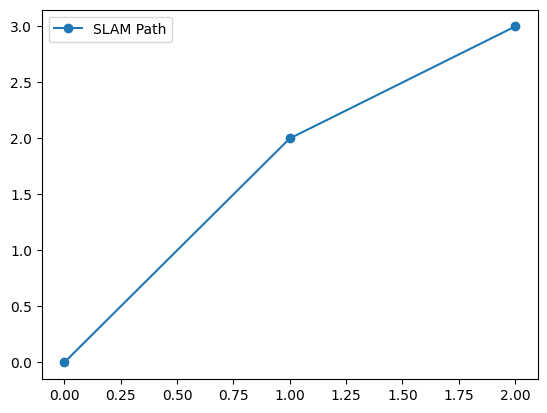

In [19]:
import matplotlib.pyplot as plt

trajectory = np.array([[0, 0], [1, 2], [2, 3]])  # Example trajectory
plt.plot(trajectory[:, 0], trajectory[:, 1], marker="o", label="SLAM Path")
plt.legend()
plt.show()
